In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import IPython.display as display

class DCGAN:
    def __init__(self, noise_dim, BATCH_SIZE):
        self.noise_dim = noise_dim
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, noise_dim])

    def make_generator_model(self):
        model = tf.keras.Sequential([
            layers.Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((7, 7, 256)),
            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ])
        return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential([
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1)
        ])
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for image_batch in tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}'):
                self.train_step(image_batch)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            self.generate_and_save_images(epoch + 1, self.seed)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs, self.seed)

    def generate_and_save_images(self, epoch, test_input):
        predictions = self.generator(test_input, training=False)

        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        imageDir = './images'
        if not os.path.exists(imageDir):
            os.makedirs(imageDir)
        imagePath = os.path.join(imageDir, 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.savefig(imagePath)
        plt.show()

In [5]:
df = pd.read_csv(os.environ.get("DATASET_PATH"), header=None)
df.head()
train_label = df[0]
train_images = df.drop(0, axis=1)
augment_images = []
for i in train_images.index:
    pixels = train_images.loc[i].values
    image = np.array(pixels).reshape(28,28)
    rotated_image = np.rot90(image, k=-1)
    flipped_horizontal = np.fliplr(rotated_image)
    augment_images.append(flipped_horizontal)

train_images = np.array(augment_images)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

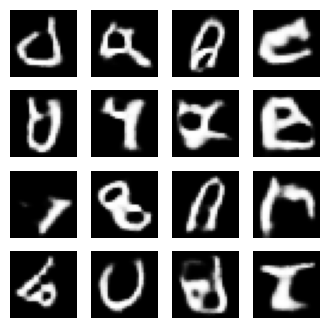

In [11]:
dcgan = DCGAN(100, BATCH_SIZE)
dcgan.train(train_dataset, 50)